In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

In [7]:
np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [8]:
df = pd.DataFrame({'data':ARMA_1_1})
df.head()

,data
0,0.496714
1,0.472694
2,0.679240
3,2.330099
4,1.905506


In [23]:
train = df[:int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

print(len(df))
print(len(train))
print(len(test))

1000
800
200


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                    window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    #베이스라인 모델들
    if method == 'mean': #평균으로 예측
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last': #마지막 값으로 예측
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    #MA 모델
    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1, 0, 1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [25]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

/tmp/ipykernel_7966/4077670050.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
/tmp/ipykernel_7966/4077670050.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
/tmp/ipykernel_7966/4077670050.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,data,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


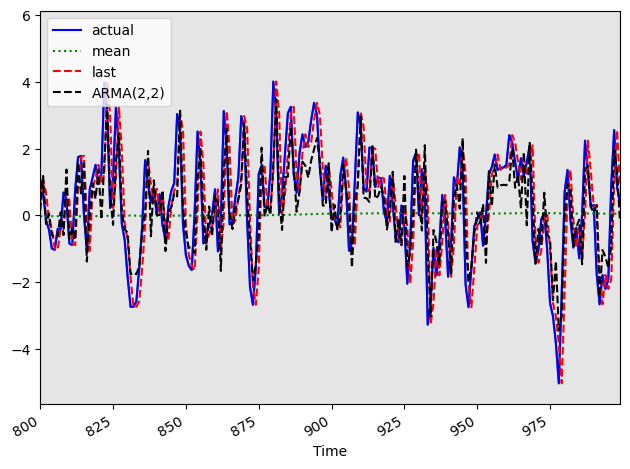

In [28]:
fig, ax = plt.subplots()

ax.plot(df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r--', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')


ax.axvspan(800, 999, color='#808080', alpha=0.2)

ax.set_xlim(800, 999)


fig.autofmt_xdate()
plt.tight_layout()

In [29]:
mse_mean = mean_squared_error(test['data'], test['pred_mean'])
mse_last_value = mean_squared_error(test['data'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['data'], test['pred_ARMA'])

print(mse_mean, mse_last_value, mse_ARMA)

2.6792528451659092 1.6761458178498734 0.9281958689211242
